## Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

## Paths

In [2]:
TRAIN = '../Data/df_train.csv'
TEST = '../Data/df_test.csv'

## Functions

In [3]:
z_score = lambda x : (x-np.mean(x,axis=0))/ np.std(x,axis=0) #code from exercise 5

## Variables and df loading

In [4]:
col = 'tab10' #colour theme

df = pd.read_csv(TRAIN) #training dataframe

attributes = list(df.columns)[:-1] #creates list of column names for later

X = df[attributes].copy() #attributes
y = df['type'].copy() #true values

y_types = {1:'wind_float', 2:'wind_non', 3:'wind_veh', 5:'container', 6:'tableware', 7:'headlamp'}
y_list = y.unique() #'y' values

X_std = z_score(X) #standardizes X as later we see they are on different scales

for i in y_list: #this changes the 'type' to a descriptive word rather than a number
    #This is more human readable for plotting later - 'y' is still using the numbers
    df['type'][df['type'] == i] = y_types[i]

<ipython-input-4-3bb2aecc6c37>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['type'][df['type'] == i] = y_types[i]


In [5]:
def Gini(df, y,threshold, class_):
    df = pd.concat([df,y], axis=1,)
    df.columns=['Att', 'class']
    #print(df.head())
    '''Takes a threshold and calc the Gini impurity of each split of the given df and class'''
    df_a = df[df['Att'] >= threshold] #check what the accepted standard for the equals bit is
    df_b = df[df['Att'] < threshold]
    '''calc and return gini impurity for each side'''
    #print(df_a)
    #print(df_b.head())
    tot_a = 0
    tot_b = 0
    
    for i in range(len(df_a)):
        #print(i)
        if df_a['class'].iloc[i] == class_:
            tot_a +=1
        
    for i in range(len(df_b)):
        #print(i)
        if df_b['class'].iloc[i] == class_:
            tot_b +=1
            
    #a
    correct_a = tot_a/len(df_a) #correct proportion
    wrong_a = (len(df_a)-tot_a)/len(df_a) #incorrect proportion
    #print(correct_a, wrong_a)
    left = correct_a *(1-correct_a) + wrong_a*(1-wrong_a)
    
    #b
    correct_b = tot_b/len(df_b) #correct proportion
    wrong_b = (len(df_b)-tot_b)/len(df_b) #incorrect proportion
    #print(correct_b, wrong_b)
    right = correct_b *(1-correct_b) + wrong_b*(1-wrong_b)
    
    return ((len(df_a)/len(df))*left) + ((len(df_b)/len(df))*right)
    
        
    
g_gain = 0.5- Gini(df['RI'],y, 1.518, 1)
g_gain

0.059668120929241564

In [6]:
def leaf_hunter(df=df, class_list=y_list):
    '''takes df and class returns highest gini gain, best class, best threshold, and 
    best attribute'''
    #So many loops! 
    best_gini_gain = 0
    best_class = ''
    best_threshold = ''
    best_att = ''

    for cl in y_list:
        '''loop through classes'''
        for a in attributes:
            tmp = df.sort_values(by=a, axis=0).copy()
                #print(a)
                #loop through attributes
            for threshold in range(len(df)-1):
                '''loop through potential thresholds'''
                if tmp[a].iloc[threshold] == tmp[a].iloc[threshold+1]:
                    pass
                else:
                    thresh = ((tmp[a].iloc[threshold] + tmp[a].iloc[threshold+1])/2)
                    #print((tmp[a].iloc[threshold], tmp[a].iloc[threshold+1]), thresh)       
                    g_gain = 0.5-Gini(df[a], y, thresh, cl)
                    if g_gain > best_gini_gain:
                        best_gini_gain = g_gain
                        best_class = cl
                        best_threshold = thresh
                        best_att = a
    return best_gini_gain, best_class, best_threshold, best_att
            
best_gini_gain, best_class, best_threshold, best_att = leaf_hunter()

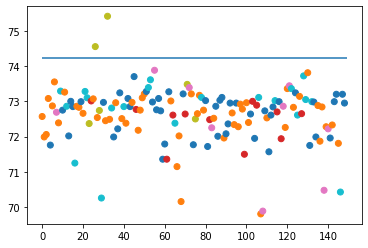

In [7]:
plt.scatter([i for i in range(149)], df[best_att], c=y, cmap=col)
plt.hlines(best_threshold, 0, 149);

0.45894196604816423 6 0.01 K


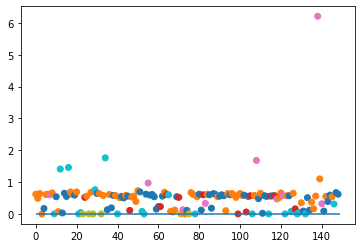

In [9]:
new_df = df[df[best_att] < best_threshold]

best_gini_gain, best_class, best_threshold, best_att = leaf_hunter(new_df)

print(best_gini_gain, best_class, best_threshold, best_att)

plt.scatter([i for i in range(149)], df[best_att], c=y, cmap=col)
plt.hlines(best_threshold, 0, 149);

0.5 2 1.523955 RI


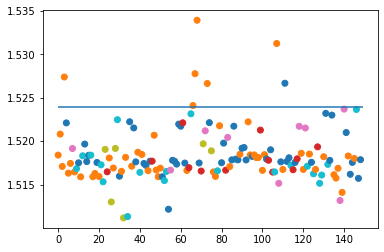

In [10]:
new_df = new_df[new_df[best_att] < best_threshold]

best_gini_gain, best_class, best_threshold, best_att = leaf_hunter(new_df)

print(best_gini_gain, best_class, best_threshold, best_att)

plt.scatter([i for i in range(149)], df[best_att], c=y, cmap=col)
plt.hlines(best_threshold, 0, 149);